# Non-uniform Field Arrays
Another notebook in the series of analysis of Mark's trap array design. Here I analyze aperiodic arrays, arrays with randomized phase from aperture to aperture, and arrays with phases that vary in other ways (linear)

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

## Randomized Input Masks
Now use an input field created with random noise-- either in phase or periodicity

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

b=0.005031, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000101


In [8]:
pts = 1000
phi_std= 1/36 # 10 degrees
pos_std=None
r_aper = 0 # aperture reflectivity
t_plate = 0 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

90 909 90 909


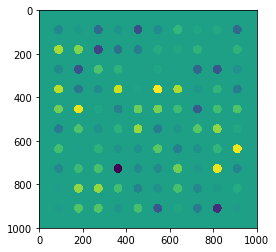

In [9]:
fig,ax = figax()
ax.imshow(angle(mask))

fname =  input_amplitude_10x10_tspot100_tplate0_phi_std2.png


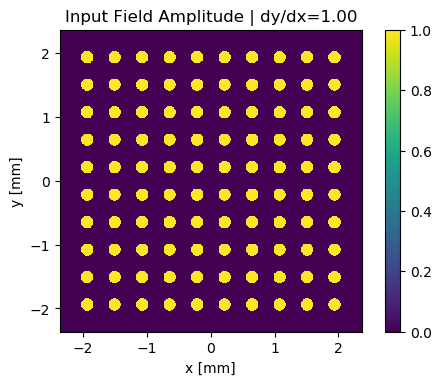

In [10]:
## plot the input field transmission

savefile=False
if pos_std is not None:
    fname = f'input_amplitude_{xnum}x{ynum}_tspot{int(100*(1-r_aper))}_tplate{int(100*t_plate)}_pos_std{int(100*pos_std/a)}a.png'
elif phi_std is not None:
    fname = f'input_amplitude_{xnum}x{ynum}_tspot{int(100*(1-r_aper))}_tplate{int(100*t_plate)}_phi_std{int(100*phi_std)}.png'
else:
#     fname = f'input_amplitude_{xnum}x{ynum}_tspot{int(100*(1-r_aper))}_tplate{int(100*t_plate)}.png'
    fname = f'bright_input_amplitude_{xnum}x{ynum}_dydx{int(dy/dx*100)}.png'

print('fname = ', fname)

plt.close()
fig,ax = figax(xlabel=r'x [mm]', ylabel=r'y [mm]')
fig.dpi=100
ax.set_title(rf'Input Field Amplitude | dy/dx={dy/dx:0.2f}') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
mmscl = 1e3
cax = ax.imshow(abs(mask), extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

In [6]:
xnum*dx/pts

3.5833333333333335e-06

In [34]:
## add custom phase to the input field:
numpi = 10
phases = array([[exp(1j*pi*(2*i/(pts - 1) - 1)) for i in range(pts)] for i in range(pts)])
mask *= phases
# plt.imshow(angle(phases))

fname =  input_phases_10x10_phi_std10deg.png
wrote file to input_phases_10x10_phi_std10deg.png


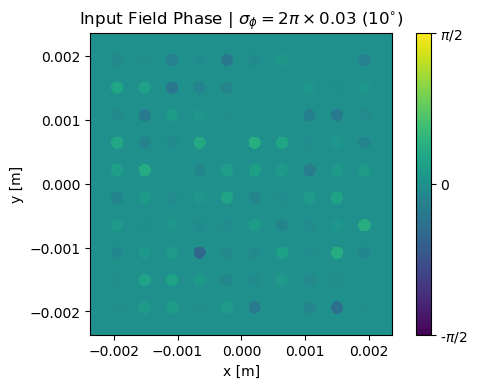

In [60]:
## plot the phases of the input mask

savefile=True
if phi_std is not None:
    fname = f'input_phases_{xnum}x{ynum}_std{int(100*phi_std)}.png'
else:
    fname = f'input_phases_{xnum}x{ynum}.png'
fname = f'input_phases_{xnum}x{ynum}_phi_std10deg.png'
print('fname = ', fname)

plt.close()
fig,ax = figax(xlabel=r'x [m]', ylabel=r'y [m]')
fig.dpi = 100
scl = 1e6
title = rf'Input Field Phase'
if phi_std is not None:
    title += rf' | $\sigma_{{\phi}}=2\pi \times {phi_std:0.2f}$ ({int(phi_std*360)}$^{{\circ}})$'
ax.set_title(title)
cax = ax.imshow(angle(mask)/(2*pi), extent=[-w, w, -w, w])
cax.set_norm(colors.Normalize(vmin=-.25, vmax=.25))
cbar = fig.colorbar(cax, ticks=arange(-.25,.5, .25))
cbar.ax.set_yticklabels([r'-$\pi$/2',0,r'$\pi$/2']) #[r'-$\pi$',r'-$\pi$/2',0,r'$\pi$/2',r'$\pi$'])

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

In [51]:
int(phi_std*100)

2

In [43]:
rf'{int(phi_std*360)}$^{\circ}$', r'$\mu$'

('10$\\mu^$', '$\\mu$')

In [14]:
arange(-.25,.5, .25)

array([-0.25,  0.  ,  0.25])

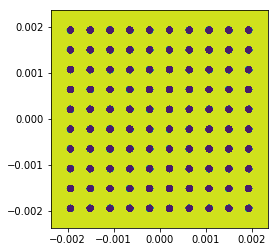

In [16]:
fig, ax = figax()
ax.contourf(x0pts, x0pts, abs(mask))

In [55]:
#TODO: take into account finite field size from mark's plate

## compute the fourier field 

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding= int(pts/2) #TODO set
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,padval=1)

f - z2 = 0
calculated field2 in 1.001317024230957 s


In [151]:
padding

500

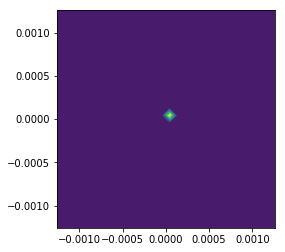

In [56]:
## plot the fourier plane intensity
x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f1/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])

fig,ax = figax(roi=b/4)
I1_xy = conjugate(field1)*field1
I1_xy /= amax(I1_xy)
ax.contourf(x1pts,x1pts,real(I1_xy))

In [58]:
savefile=False

In [45]:
zTalbotx, zTalboty

(0.00010085454545454543, 0.0001501119054545454)

In [57]:
## compute and plot the output intensity

midpt = int(field1.shape[0]/2)
ints2 = []
labels = []

zvals = [0, zTalbotx, zTalboty]
zlabs = ['zFocus', 'zTalbot_x', 'zTalbot_y']

for dz,leg in zip(zvals,zlabs):

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = int(pts/2)
    z2 = f2 - dz
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True)

    if not t_plate == 0:
        if phi_std is not None:
            fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_phi_std{int(100*phi_std)}_{xnum}x{ynum}.png'
        elif pos_std is not None:
            fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_pos_std{int(100*pos_std/a)}a_{xnum}x{ynum}.png'
        else:
            fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_uniform_{xnum}x{ynum}.png'
        # fname = f'dark_I2xy_z0um_linear_phase_npi_to_pi_{xnum}x{ynum}.png'
    else:
        if phi_std is not None:
            fname = f'bright_I2xy_z{(f2 - z2)*1e6:0.0f}um_phi_std{int(100*phi_std)}_{xnum}x{ynum}.png'
        elif pos_std is not None:
            fname = f'bright_I2xy_z{(f2 - z2)*1e6:0.0f}um_pos_std{int(100*pos_std/a)}a_{xnum}x{ynum}.png'
        else:
            fname = f'bright_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(dy/dx*100)}_{xnum}x{ynum}.png'
        # fname = f'dark_I2xy_z0um_linear_phase_npi_to_pi_{xnum}x{ynum}.png'
    print(fname)

    I2_xy = conjugate(field2)*field2
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy = I2_xy/I2xy_max 

    # x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    title = rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m]'
    if phi_std is not None:
        title += rf' | $\sigma_{{\phi}}=2\pi \times {phi_std:0.2f}$'
    elif pos_std is not None:
        title += rf' | $\sigma_{{ij}}={(pos_std/a):0.2f}a$'
    else: 
        title += f' | dy/dx={dy/dx:0.2f}' #Uniform input $\phi$
    title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    #     cax.set_norm(colors.Normalize(vmin=0, vmax=1))
    fig.colorbar(cax, ticks=arange(0,1.2,.2))

    if savefile:
        plt.savefig(fname, bbox_inches='tight')
        print('wrote file to',fname)
        plt.close()
#     savefile = False 
    
    ints2.append(I2_xy)
    labels.append(leg+f' ({(z2 - f2)*1e6:0.0f} [um])')

f - z2 = 0.0
calculated field2 in 0.9803788661956787 s
bright_I2xy_z0um_phi_std2_10x10.png
wrote file to bright_I2xy_z0um_phi_std2_10x10.png
f - z2 = 0.0001008545454545453
calculated field2 in 1.0671474933624268 s
bright_I2xy_z101um_phi_std2_10x10.png
wrote file to bright_I2xy_z101um_phi_std2_10x10.png
f - z2 = 0.0001008545454545453
calculated field2 in 0.9843683242797852 s
bright_I2xy_z101um_phi_std2_10x10.png
wrote file to bright_I2xy_z101um_phi_std2_10x10.png


In [162]:
x2pts[midpt+30]

2.6400495000000234e-06

In [69]:
dy/dx*100, 100*dy/dx

(122.0, 121.99999999999999)

In [200]:
x2pts[midpt+39]

3.419080500000028e-06

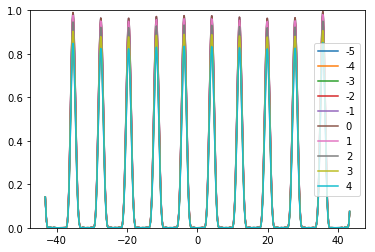

In [221]:
for i in arange(-5,5,1):
    plt.plot(x2pts*scl,ints2[0][:,midpt+39+i],label=i)
# plt.plot(x2pts*scl,ints2[0][:,midpt+39],label=i)
plt.ylim(0,1)
plt.legend()

In [222]:
lines = [[],[],[]]
lines[0] = ints2[0][:,midpt+39]
lines[1] = ints2[1][:,midpt+39]
lines[2] = ints2[2][:,midpt+75]

In [231]:
cvals=['gold','green','orange']
savefile=True

In [237]:
fname = f'bright_I2xz_zcompare_dydx{int(dy/dx*100)}_{xnum}x{ynum}.png'
print(fname)

fig,ax=figax(aspect=None,xlabel=r'$y [\mu m]$',ylabel='Intensity')
for line,label,color in zip(lines,labels,cvals):
    ax.plot(x2pts*scl, line, label=label, color=color)
ax.set_title(f'Intensity2 xz Slices | dy/dx={dy/dx:0.2f}')
ax.set_ylim(0,1)
ax.legend()

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)
savefile = False 

bright_I2xz_zcompare_dydx122_10x10.png
wrote file to bright_I2xz_zcompare_dydx122_10x10.png


## program to compute output field for a range of specified parameter values

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 0.7*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params
pts = 1000
phi_std=None
t_aper = .49 # physical param
t_plate = 1 # physical param
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, aperture=1-t_aper, plate=t_plate)

## misc
padding = 100 # pad the field with 100 rows/cols of zeros to increase fft res

b=0.005031, a=0.0001, dx=0.00043, dy=0.000301, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000049


In [50]:
## compute the output field for various values of dy using this packaged prodedure

# save contour plots as pngs?
showcontour=False # must be true in order to save contour to file
showphases=False # must be true in order to save phases to file
savefile=False

# scaled real space pts for output array
scl = 1e6

lines = []
labels = []

for alpha in arange(.7,1.3,.05): # loop over some parameter that varies what the phases are doing, or just make a list of phase lambdas to loop over

    ## COMPUTE FOURIER PLANE FIELD
    
    # propogate the field and apply a filter in the Fourier plane
    padding=200 #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,padval=1)

    ## COMPUTE OUTPUT INTENSITY

    # always run with z2 = f2 first
    for z in [0, zTalbotx]:
        z2 = f2 - z
        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr,padding)

        I2_xy = conjugate(field2)*field2
        if f2 - z2 == 0:
            I2xy_max = amax(I2_xy) 
#             print(f"set the I2xy_max={I2xy_max}")
        I2_xy = 1 - I2_xy/I2xy_max 
    
        fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

        ## OPTIONALLY SHOW/SAVE INTENSITY CONTOUR AND INPUT PHASE PLOTS 
        
        if showcontour:
            fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
            fig.dpi = 200
            if f2 - z2 == 0:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
            else:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy))
            fig.colorbar(cax, ticks=arange(0,1.2,.2))
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
            if savefile:
                plt.savefig(fname, bbox_inches='tight')
                print('wrote file to',fname)
                plt.close()
                
        if showphases:
            if phi_std is not None:
                fname = f'input_phases_{xnum}x{ynum}_std{int(100*phi_std)}.png'
            else:
                fname = f'input_phases_{xnum}x{ynum}.png'
            print('fname = ', fname)

            plt.close()
            fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
            fig.dpi = 100
            scl = 1e6
            title = rf'Input Field Phases '
            if phi_std is not None:
                title += rf'$\sigma_{{\phi}}=2\pi \times {phi_std:0.2f}$'
            ax.set_title(title)
            cax = ax.imshow(angle(mask)/(2*pi), extent=[-w, w, -w, w])
            cax.set_norm(colors.Normalize(vmin=-.5, vmax=.5))
            cbar = fig.colorbar(cax, ticks=arange(-.5,.75, .25))
            cbar.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2',0,r'$\pi$/2',r'$\pi$'])

            if savefile:
                plt.savefig(fname, bbox_inches='tight')
                print('wrote file to',fname)

                
    ## append a slice of the intensity in y at x = 3.21 um, z = zTalbotx
    lines.append(I2_xy[:,midpt+11])
    labels.append(f'dy/dx={dy/dx:0.2f}')

calculated field1 in 13.833039045333862 s
f2 - z2 = 0.0
calculated field2 in 0.7210707664489746 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7958729267120361 s
calculated field1 in 12.732946634292603 s
f2 - z2 = 0.0
calculated field2 in 0.7061119079589844 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7829060554504395 s
calculated field1 in 12.46167254447937 s
f2 - z2 = 0.0
calculated field2 in 0.6881611347198486 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7868936061859131 s
calculated field1 in 13.167784452438354 s
f2 - z2 = 0.0
calculated field2 in 0.7220687866210938 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7978682518005371 s
calculated field1 in 12.585339069366455 s
f2 - z2 = 0.0
calculated field2 in 0.7858946323394775 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.8078393936157227 s
calculated field1 in 12.66912031173706 s
f2 - z2 = 0.0
calculated field2 in 0.7071089744567871 s
f2 - z2 = 0.0001008545454545453
calculated f

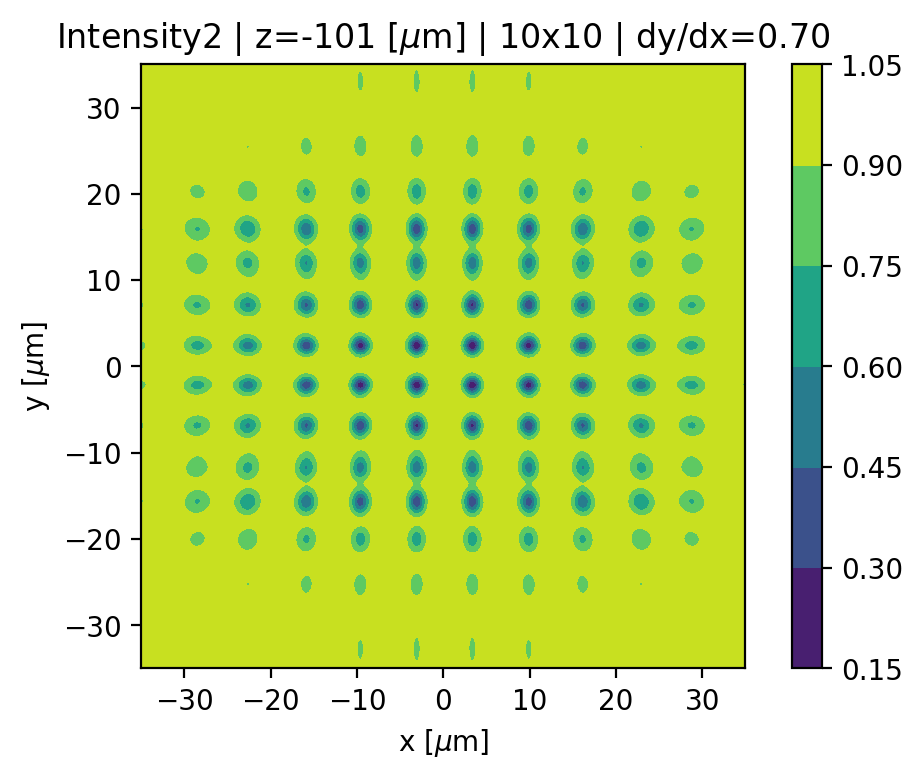

In [14]:
Image('dark_I2xy_z101um_dydx70_10x10.png')

wrote file to i2_slice_x-3.21um_z100.85um_dydx100_125.png


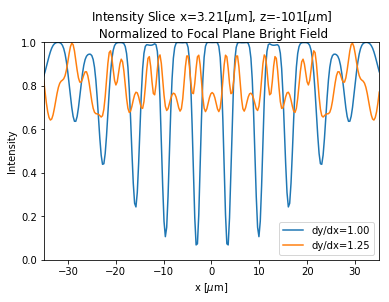

In [76]:
## plot the lines calculated above -- intensity slices in y

savefile = True
fname = f'i2_slice_x{x2pts[midpt-12]*scl:0.2f}um_z{(f2-z2)*scl:0.2f}um_dydx100_125.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'Intensity',aspect=None)
ax.set_title(rf'Intensity Slice x={x2pts[midpt+11]*scl:0.2f}[$\mu$m], z={(z2-f2)*scl:0.0f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1)
# stop_idx = 7
# for line,label in zip(lines[:stop_idx],labels[:stop_idx]): 
#     ax.plot(x2pts*scl, line, label=label)
for i in [6,11]:
    ax.plot(x2pts*scl, lines[i], label=labels[i])
ax.legend(loc='lower right')

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

## various function testing

In [7]:
def spot_mask(xnum, ynum, a, dx, dy, pts, pos_std=None, phi_std=None, plate=0, aperture=1):
    """
    Warning: this will may not work as expected if xnum or ynum is odd
    Args:
        xnum: # of spots in x (columns)
        ynum " " " " y (rows)
        a: aperture spot radius
        dx: center-center distance in x
        dy: " " " " y
        pts: number of pts in one dimesnsion in the 2D array output. ie output
            mask is pts x pts
        pos_std: std for randomness added to spot centers. should be a decimal 
            representing percentage of 'a', e.g. 0.10 would give normally
            distributed noise with sigma = 0.10*a
        phi_std: std for random phase given to each aperture unit cell. units are in 2*pi and phase is sampled from
            from a normal dist. phi_std = 0.1 would correspond to sigma 0.1*2*pi radians, so there is a 
            +/- 10% spread of phase over the apertures compared to the plate. Note that to create mask where 
            this phase is only applied to the spot, plate must be set to 0. after creating the mask with this function,
            you can then add a constant to offset the transmittance of the whole mask
        plate: 0 by default; plate transmittance
        aperture: 1 by default; aperture transmittance
    Returns: 
        2D array, xarr, w: binary mask of spots, 1D array of real space x coordinates, and real space half width.
            The realspace full width of the grid 2*w = (max(xnum,ynum) + 1)*dx
    """

    w = (max(xnum,ynum) + 1)*dx/2 # array real space half-width 
    res = 2*w/pts # real space distance between adjacent pts

    # make subgrid and build a single aperture mask:
    subpts = int(2*a/res) # number of pts to make a side length 2*a
    assert subpts % 2 == 0, "try a slightly different even number of points so that sub-array width is even"
    
    sarr,smidpt,srr,sphi = get_meshgrid(a, subpts, polar=True)
    smask = zeros((subpts,subpts))
    bin_mask_outer = copy(smask) # fill with ones outside of the aperture
    bin_mask_inner = copy(smask) # fill with ones inside of the aperture
    
    # TODO: build binary phase mask component matrices as on the whiteboard
    if phi_std is not None:
        phase = lambda :random.normal(0, 2*pi*phi_std)
    else:
        phase = lambda :0
    
    for j in range(smidpt):
        for i in range(smidpt):
            transmit = int(srr[i,j] < a)
            if transmit:
                smask[i,j] = aperture
            else:
                smask[i,j] = plate
            bin_mask_inner[i,j] = transmit
            bin_mask_outer[i,j] = 1 - transmit
                
    smask = from_quadrant3(smask[:smidpt,:smidpt], smask)
    bin_mask_inner = from_quadrant3(bin_mask_inner[:smidpt,:smidpt], bin_mask_inner)
    bin_mask_outer = from_quadrant3(bin_mask_outer[:smidpt,:smidpt], bin_mask_outer)
    
    # the centroids of the apertures
    xpts, ypts = get_grid(dx,dy,xnum,ynum)
    
    # add noise, optionally
    if pos_std is not None:
        # TODO: add noise from a normal dist of sigma = std*a 
        xpts = array([x + nx for x,nx in zip(xpts,random.normal(0,pos_std,xnum*ynum))])
        ypts = array([y + ny for y,ny in zip(ypts,random.normal(0,pos_std,xnum*ynum))])
    
    # convert centroids to mask indices
    yidcs = [int((y + w)/res) for y in ypts]
    xidcs = [int((x + w)/res) for x in xpts]
    
    midpt = int(pts/2)
    mask = full((pts, pts), plate, complex)

    # build the mask
    for i,j in zip(yidcs,xidcs):
        mask[i-smidpt:i+smidpt,j-smidpt:j+smidpt] = smask #*(bin_mask_outer + bin_mask_inner*exp(1j*phase()))
            
    # real space coordinates
    xarr = array([i*res - w for i in range(pts)])
            
    return mask, xarr, w

In [5]:
# params for spot_mask
a = 1e-4
dx = 4.3*a
dy = dx
xnum = ynum = 10

pts = 1000
phi_std=None
pos_std=0.2*a
t_aper = .49
t_plate = 1
mask, x0pts, w, xarr, yarr, xidcs, yidcs, smask = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-t_aper, plate=t_plate)

In [182]:
# get every ynumth element
mask

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]])

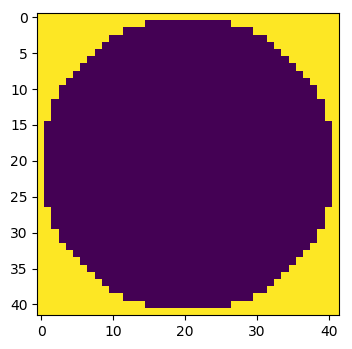

In [183]:
fig,ax = figax()
fig.dpi = 100
ax.imshow(smask)

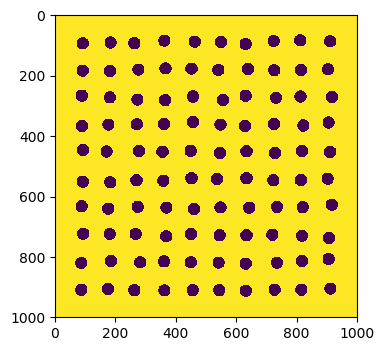

In [6]:
plt.close()
fig,ax = figax()
fig.dpi = 100
ax.imshow(real(mask))

In [113]:
mask[100-smidpt: 100+smidpt, 50-smidpt:50+smidpt].shape

(42, 42)

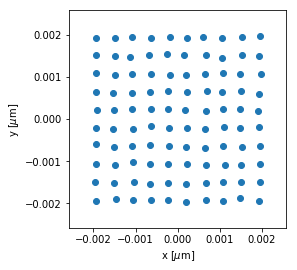

In [132]:
fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]', roi=dx*(xnum-4))
ax.scatter(xarr, yarr)

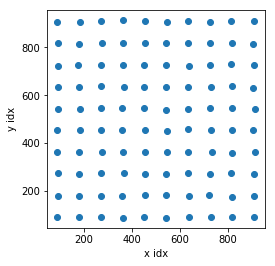

In [99]:
fig,ax = figax(xlabel=r'x idx', ylabel=r'y idx')
ax.scatter(xidcs, yidcs)

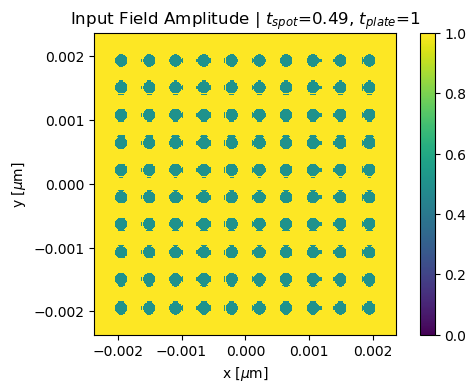

In [100]:
fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi=100
ax.set_title('Input Field Amplitude | $t_{spot}$=0.49, $t_{plate}$=1',)
cax = ax.imshow(real(mask), extent=[-w,w,-w,w])
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)